# Stock Selection for the Defensive Investor
**Purpose.** Purpose of this notebook is to select companies that pass Ben Graham's test criteria for the *defensive investor*, as described in *Chapter 14 of Intelligent Investor*.
The criteria has 7 tests:
1. **Adequate Size of the Enterprise.** Not less than \\$100 million of annual sales for an industrial company and, not less than \\$50 million of total assets for a public utility.


2. **A Sufficiently Strong Financial Condition.** For industrial companies current assets should be at least twice current liabilities—a so-called two-to-one current ratio. Also, long-term debt should not exceed the net current assets (or “working capital”). For public utilities the debt should not exceed twice the stock equity (at book value).


3. **Earnings Stability.** Some earnings for the common stock in each of the past ten years.


4. **Dividend Record.** Uninterrupted payments for at least the past 20 years.


5. **Earnings Growth.** A minimum increase of at least one-third in per-share earnings in the past ten years using three-year averages at the beginning and end.


6. **Moderate Price/Earnings Ratio.** Current price should not be more than 15 times average earnings of the past three years.


7. **Moderate Ratio of Price to Assets.** Current price should not be more than 1½ times the book value last reported. However, a multiplier of earnings below 15 could justify a correspondingly higher multiplier of assets. As a rule of thumb we suggest that the product of the multiplier times the ratio of price to book value should not exceed 22.5.

In [1]:
import sys
import pandas as pd
import numpy as np
import quandl
import os
import warnings
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
import pandas_datareader as pdr
import matplotlib.pyplot as plt
#import humanize

warnings.filterwarnings('ignore')
quandl.ApiConfig.api_key = os.getenv('QUANDL_APY_KEY')
print(f'Python version: {sys.version}')
print(f'Pandas version: {pd.__version__}\nNumpy version: {np.__version__}')

Python version: 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version: 0.24.0
Numpy version: 1.14.2


## Getting necessary data for a given company
First step is to get necessary data to determine if a given company pass or fails Ben Graham's test criteria for the *defensive investor*, as described in *Chapter 14 of Intelligent Investor*. Using [Quandl SF1 | Core US Fundamentals Data](https://www.quandl.com/databases/SF1)

In [2]:
ticker = 'NKE'

def get_data(ticker, dt=datetime.today(), force_download=False):
    fname = os.path.join(os.getcwd(), 'data_defensive', ticker.lower() + '.csv')
    if force_download or not os.path.isfile(fname):
        columns = ['calendardate', 'datekey', 'revenue', 'currentratio', 'eps', 'dps', 'bvps', 'price']
        df = quandl.get_table('SHARADAR/SF1', dimension='ARY', ticker=ticker, qopts={"columns":columns})
        df = df[df['datekey'] <= dt]
        df.sort_values('calendardate', inplace=True)
        df.to_csv(fname)
    else:
        df = pd.read_csv(fname, parse_dates=['calendardate', 'datekey'])
        
    df = df.groupby('calendardate').tail(1)
    return df

%time get_data(ticker, force_download=False).head()

CPU times: user 11.4 ms, sys: 4.1 ms, total: 15.5 ms
Wall time: 13.3 ms


,None,calendardate,datekey,revenue,currentratio,eps,dps,bvps,price
0,20,1998-12-31,1998-08-26,9553100000,2.073,0.172,0.057,1.419,4.673
1,19,1999-12-31,1999-08-26,8776900000,2.256,0.199,0.060,1.477,6.423
2,18,2000-12-31,2000-08-29,8995100000,1.681,0.263,0.060,1.453,5.250
3,17,2001-12-31,2001-08-09,9488800000,2.029,0.273,0.060,1.622,6.081
4,16,2002-12-31,2002-08-14,9893000000,2.264,0.310,0.045,1.798,5.531


In [3]:
get_data(ticker, dt=datetime(2018, 6, 1)).tail()

,None,calendardate,datekey,revenue,currentratio,eps,dps,bvps,price
16,4,2014-12-31,2014-07-25,27799000000,2.724,1.525,0.465,6.233,38.86
17,3,2015-12-31,2015-07-23,30601000000,2.522,1.900,0.540,7.428,57.00
18,2,2016-12-31,2016-07-21,32376000000,2.804,2.210,0.620,7.307,56.99
19,1,2017-12-31,2017-07-20,34350000000,2.934,2.560,0.700,7.551,59.10
20,0,2018-12-31,2018-07-25,36397000000,2.506,1.190,0.780,6.130,77.16


## Check if a given company pass the 7 criteria
Second step is to implement the criteria and check if a given company pass it or not.

In [4]:
def criteria_defensive_investor(ticker_or_list, verbose=False, dt=datetime.today()):
    list_tickers = []
    if isinstance(ticker_or_list, str):
        list_tickers.append(ticker_or_list)
    else:
        list_tickers = ticker_or_list
        
    summary_columns = ['ticker', 'last_date', 'first_date', 'revenue', 'current_ratio', 
                       'positive_eps_p10yrs_count', 'dividend_distribution_p20yrs_count', 
                       'earnings_change_p10yrs', 'pe', 'pb', 'pexpb', 'size_criteria', 
                       'financial_condition_criteria', 'earnings_stability_criteria', 
                       'dividend_record_criteria', 'earnings_growth_criteria', 'pe_criteria', 
                       'pb_criteria', 'full_criteria']
    df_ = pd.DataFrame(columns=summary_columns)
        
    for ticker in tqdm(list_tickers):
        if verbose:
            print('\nTest for ' + ticker + ':')
        data = get_data(ticker, dt=dt)

        # In case of no data
        if data.shape[0] == 0:  # No data
            if verbose:
                print('- No data available')
            df_.append(pd.Series([float('NaN')] * len(summary_columns), index=summary_columns), ignore_index=True)
            df_.at[df_.index[-1], 'ticker'] = ticker
            continue

        # Size criteria
        size_criteria = data['revenue'].values[-1] > 100000000

        # Financial condition criteria
        if data['currentratio'].values[-1] is not None:
            current_ratio = data['currentratio'].values[-1]
            financial_condition_criteria = current_ratio > 2
        else:
            current_ratio = float('NaN')
            financial_condition_criteria = False

        # Earnings stability criteria
        earnings_stability_criteria = (data['eps'].tail(10) > 0).all()

        # Dividends record criteria
        dividend_record_criteria = (data['dps'].tail(20) > 0).all()

        # Earnings growth criteria
        last_year = pd.to_datetime(data['calendardate'].values[-1]).year
        eps_0 = data[(data['calendardate'].dt.year > last_year - 13) & 
                     (data['calendardate'].dt.year <= last_year - 10)]['eps'].mean()
        eps_1 = data[(data['calendardate'].dt.year > last_year - 3) & 
                     (data['calendardate'].dt.year <= last_year)]['eps'].mean()
        earnings_growth_criteria = (np.float64(eps_1) / eps_0) > 1.33

        # P/E ratio criteria
        current_price = data['price'].values[-1]
        pe = current_price / eps_1
        pe_criteria = pe < 15

        # Price to Assets criteria
        pb = current_price / data['bvps'].values[-1]
        pb_criteria = pb < 1.5
        if (pe * pb < 22.5):
            pb_criteria = True

        # Full criteria
        full_criteria = size_criteria and financial_condition_criteria and earnings_stability_criteria \
            and dividend_record_criteria and earnings_growth_criteria and pe_criteria and pb_criteria
        
        # Add to dataframe
        my_dic = {'ticker': ticker, 
                  'last_date': data['calendardate'].values[-1], 
                  'first_date': data['calendardate'].values[0], 
                  'revenue': data['revenue'].values[-1], 
                  'current_ratio': current_ratio, 
                  'positive_eps_p10yrs_count': data.tail(10)[data['eps'] > 0]['eps'].count(), 
                  'dividend_distribution_p20yrs_count': data.tail(20)[data['dps'] > 0]['dps'].count(), 
                  'earnings_change_p10yrs': (np.float64(eps_1) / eps_0), 
                  'pe': pe, 
                  'pb': pb, 
                  'pexpb': pe * pb,
                  'size_criteria': size_criteria, 
                  'financial_condition_criteria': financial_condition_criteria, 
                  'earnings_stability_criteria': earnings_stability_criteria, 
                  'dividend_record_criteria': dividend_record_criteria, 
                  'earnings_growth_criteria': earnings_growth_criteria, 
                  'pe_criteria': pe_criteria, 
                  'pb_criteria': pb_criteria, 
                  'full_criteria': full_criteria}
        df_.loc[len(df_)] = my_dic 

        if verbose:
            print('- Size criteria: \t\t' + str(size_criteria) + 
                  '\tRevenues of $' + humanize.intword(data['revenue'].values[-1]) + ' (threshold is $100 million)')
            print('- Financial condition criteria: ' + str(financial_condition_criteria) + 
                  '\tCurrent ratio of %1.2f' % current_ratio + ' (threshold is 2.0)')
            print('- Earnings stability criteria: \t' + str(earnings_stability_criteria) + 
                  '\tPositive earnings in %d of past 10 years' % data.tail(10)[data['eps'] > 0]['eps'].count())
            print('- Dividend record criteria: \t' + str(dividend_record_criteria) + 
                  '\tDistribution of dividend in %d of past 20 years' % data.tail(20)[data['dps'] > 0]['dps'].count())
            print('- Earnings growth criteria: \t' + str(earnings_growth_criteria) + 
                  '\tEarnings change of %+.0f%%' % (100 * ((np.float64(eps_1) / eps_0) - 1)) + ' in past 10 years (minimum is +33%)')
            print('- Moderate P/E ratio criteria: \t' + str(pe_criteria) + 
                  '\tCurrent price is %1.1fx avg P3yrs earnings (limit is 15)' % pe)
            print('- Moderate P/B ratio criteria: \t' + str(pb_criteria) + 
                  '\tCurrent price is %1.1fx last book value (limit 1.5), \n\t\t\t\t\tand PE * PB is %1.1f (limit 22.5)' % (pb, pe * pb))
            print('- Full criteria: \t\t' + str(full_criteria))
    
    return df_


In [5]:
criteria_defensive_investor('AAPL').transpose()

,0
ticker,AAPL
last_date,2018-12-31 00:00:00
first_date,1997-12-31 00:00:00
revenue,265595000000
current_ratio,1.124
positive_eps_p10yrs_count,10
dividend_distribution_p20yrs_count,7
earnings_change_p10yrs,17.4602
pe,21.0071
pb,9.29778


In [7]:
criteria_defensive_investor('AAPL', dt=datetime(2018, 6, 1)).transpose()

,0
ticker,AAPL
last_date,2018-12-31 00:00:00
first_date,1997-12-31 00:00:00
revenue,265595000000
current_ratio,1.124
positive_eps_p10yrs_count,10
dividend_distribution_p20yrs_count,7
earnings_change_p10yrs,17.4602
pe,21.0071
pb,9.29778


## Bulk test it in DJIA companies

In [8]:
def get_djia_symbols():
    #data = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")
    #table = data[1]
    #sliced_table = table[1:]
    #header = table.iloc[0]
    #corrected_table = sliced_table.rename(columns=header)
    #return corrected_table['Symbol'].tolist()
    
    data = pd.read_html("https://www.cnbc.com/dow-30/")
    table = data[0]
    return table['Symbol'].tolist()

In [9]:
df_djia = criteria_defensive_investor(get_djia_symbols(), dt=datetime(2009, 1, 1))
df_djia.head()

,ticker,last_date,first_date,revenue,current_ratio,positive_eps_p10yrs_count,dividend_distribution_p20yrs_count,earnings_change_p10yrs,pe,pb,pexpb,size_criteria,financial_condition_criteria,earnings_stability_criteria,dividend_record_criteria,earnings_growth_criteria,pe_criteria,pb_criteria,full_criteria
0,AXP,2017-12-31,1993-12-31,30712000000,NaN,10,20,1.442692,21.163994,4.688984,99.237622,True,False,True,True,True,False,False,False
1,AAPL,2018-12-31,1997-12-31,265595000000,1.124,10,7,17.460224,21.007087,9.297782,195.319314,True,False,True,False,True,False,False,False
2,BA,2017-12-31,1997-12-31,93392000000,1.158,10,20,2.497400,35.787647,574.916388,20574.905015,True,False,True,True,True,False,False,False
3,CAT,2017-12-31,1997-12-31,45462000000,1.346,9,20,0.310641,102.114894,6.877606,702.306035,True,False,False,True,False,False,False,False
4,CSCO,2008-12-31,1995-12-31,39540000000,2.576,9,0,6.414048,19.348703,3.844700,74.389963,True,True,False,False,True,False,False,False


### Analysis
Let's analyze how many companies pass stock selection criteria for the defensive investor as proposed by Ben Graham, today.

In [10]:
def analysis(df):
    c1 = len(df[df['size_criteria'] == True]['ticker'].tolist())
    c2 = len(df[df['financial_condition_criteria'] == True]['ticker'].tolist())
    c3 = len(df[df['earnings_stability_criteria'] == True]['ticker'].tolist())
    c4 = len(df[df['dividend_record_criteria'] == True]['ticker'].tolist())
    c5 = len(df[df['earnings_growth_criteria'] == True]['ticker'].tolist())
    c6 = len(df[df['pe_criteria'] == True]['ticker'].tolist())
    c7 = len(df[df['pb_criteria'] == True]['ticker'].tolist())

    c8 = len(df[(df['size_criteria'] == True) & 
                (df['financial_condition_criteria'] == True) & 
                (df['earnings_stability_criteria'] == True) & 
                (df['dividend_record_criteria'] == True) & 
                (df['earnings_growth_criteria'] == True)]['ticker'].tolist())

    cdi = len(df[df['full_criteria'] == True]['ticker'].tolist())

    print(f'{c1:4d} companies passing size criteria of minimum $100 million revenues')
    print(f'{c2:4d} companies passing financial condition criteria of minimum 2 current ratio')
    print(f'{c3:4d} companies passing earnings stability criteria of positive earnings in past 10 years')
    print(f'{c4:4d} companies passing dividend record criteria of uninterrupted payments in past 20 years')
    print(f'{c5:4d} companies passing earnings growth criteria of minimum 33% growth in past 10 years')
    print(f'{c6:4d} companies passing moderate PE ratio criteria of maximum 15')
    print(f'{c7:4d} companies passing moderate PB ratio criteria of maximum 1.5, or PE * PB of maximum 22.5')
    print(f'{c8:4d} companies passing all except moderate PE and PB ratio criteria')
    print(f'{cdi:4d} companies passing all criteria')
    
    df['count_successful_criteria'] = df.apply(lambda row: sum([row['size_criteria'], 
                                                                row['financial_condition_criteria'], 
                                                                row['earnings_stability_criteria'], 
                                                                row['dividend_record_criteria'], 
                                                                row['earnings_growth_criteria'], 
                                                                row['pe_criteria'], 
                                                                row['pb_criteria']]), axis=1)
    
    df['count_successful_criteria_except_pepb'] = df.apply(lambda row: sum([row['size_criteria'], 
                                                                row['financial_condition_criteria'], 
                                                                row['earnings_stability_criteria'], 
                                                                row['dividend_record_criteria'], 
                                                                row['earnings_growth_criteria']]), axis=1)


In [11]:
analysis(df_djia)

print('\nCompanies passing first 5 criteria: ' + 
      str(df_djia[(df_djia['size_criteria'] == True) & 
              (df_djia['financial_condition_criteria'] == True) & 
              (df_djia['earnings_stability_criteria'] == True) & 
              (df_djia['dividend_record_criteria'] == True) & 
              (df_djia['earnings_growth_criteria'] == True)]['ticker'].tolist()))

print('Companies passing all criteria: '+ str(df_djia[(df_djia['full_criteria'] == True)]['ticker'].tolist()))

  30 companies passing size criteria of minimum $100 million revenues
   3 companies passing financial condition criteria of minimum 2 current ratio
  27 companies passing earnings stability criteria of positive earnings in past 10 years
  24 companies passing dividend record criteria of uninterrupted payments in past 20 years
  21 companies passing earnings growth criteria of minimum 33% growth in past 10 years
   3 companies passing moderate PE ratio criteria of maximum 15
   4 companies passing moderate PB ratio criteria of maximum 1.5, or PE * PB of maximum 22.5
   1 companies passing all except moderate PE and PB ratio criteria
   0 companies passing all criteria

Companies passing first 5 criteria: ['NKE']
Companies passing all criteria: []


As we can see, no company pass all 7 criteria. **Nike** is the closest one, passing all first 5, but failing the last 2 criteria, which are related to company's current price attractiveness.

Now, let's count how many criteria each company pass and analyze that.

In [20]:
summary_columns = ['ticker', 'current_ratio', 
                       'positive_eps_p10yrs_count', 'dividend_distribution_p20yrs_count', 
                       'earnings_change_p10yrs', 'pe', 'pb', 'pexpb', 'count_successful_criteria', 
                   'count_successful_criteria_except_pepb']

df_djia.sort_values('count_successful_criteria_except_pepb', ascending=False)[summary_columns] 
#[['ticker', 'count_successful_criteria']]

,ticker,current_ratio,positive_eps_p10yrs_count,dividend_distribution_p20yrs_count,earnings_change_p10yrs,pe,pb,pexpb,count_successful_criteria,count_successful_criteria_except_pepb
20,PFE,2.146,10,11,2.810903,13.503030,2.322285,31.357882,6,5
19,NKE,2.661,10,11,4.575581,18.182973,3.587365,65.228967,5,5
0,AXP,NaN,10,15,2.524555,14.012618,4.724527,66.202989,5,4
11,INTC,2.787,10,12,1.094387,17.518625,2.783393,48.761209,4,4
28,WMT,0.814,10,14,4.176471,18.549296,3.251651,60.315839,4,4
27,WBA,1.570,10,12,3.728155,13.125000,1.938163,25.438394,5,4
24,UTX,1.263,10,12,3.390390,18.991143,3.284920,62.384380,4,4
21,PG,0.792,10,12,2.505474,20.687546,3.100467,64.141056,4,4
16,MMM,1.835,10,13,2.705671,15.958084,4.839881,77.235232,4,4
14,JPM,NaN,10,11,1.337188,10.986486,1.120514,12.310510,6,4


In [48]:
def get_closeadj_prices(ticker, start_date, end_date=datetime.today()):
    result = quandl.get_table('SHARADAR/SEP', ticker=ticker, qopts={"columns":["date", "close"]}, 
                          date={'gte': start_date, 'lte': end_date})
    result.set_index('date', inplace=True)
    result.sort_index(inplace=True)
    result.rename(columns={'close': ticker}, inplace=True)
    return result

def get_spy(start_date, end_date=datetime.today()):
    result = pdr.get_data_yahoo(symbols='SPY', start=start_date, end=end_date)
    result.rename(columns={'Adj Close': 'SPY'}, inplace=True)
    return result[['SPY']]

df0 = get_spy(datetime(2009, 1, 1))

In [71]:
list_tickers = ['NKE', 'AXP', 'PFE']
list_companies = []
for ticker in list_tickers:
    list_companies.append(get_closeadj_prices(ticker, datetime(2009, 1, 1)))

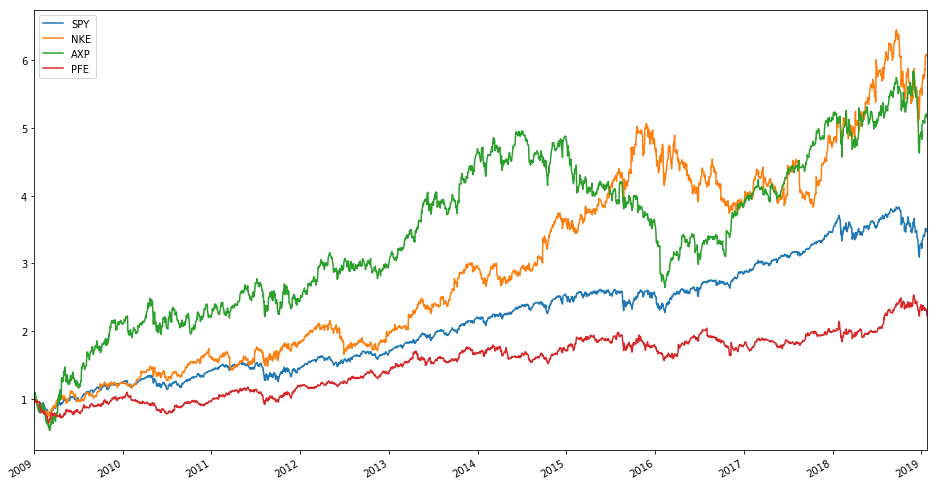

In [72]:
result = pd.concat([df0] + list_companies, axis=1)
result = result / result.ix[0, :]
result.plot(figsize=(16, 9))

In [73]:
def get_daily_pes(ticker, start_date, end_date=datetime.today()):
    result = quandl.get_table('SHARADAR/DAILY', ticker=ticker, qopts={"columns":["date", "pe"]}, 
                          date={'gte': start_date, 'lte': end_date})
    result.set_index('date', inplace=True)
    result.sort_index(inplace=True)
    result.rename(columns={'pe': ticker}, inplace=True)
    return result

In [100]:
list_companies_pes = []
for ticker in ['NKE', 'AXP']:
    list_companies_pes.append(get_daily_pes(ticker, datetime(1999, 1, 1)))

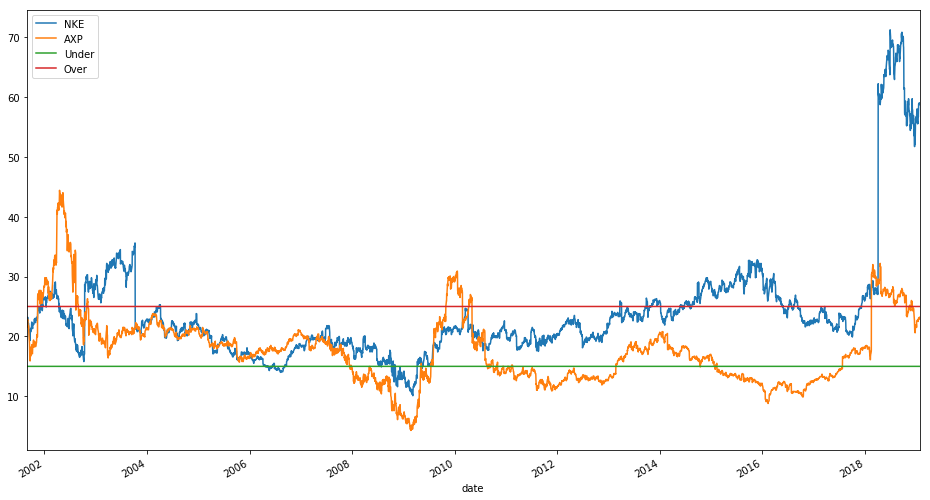

In [101]:
result2 = pd.concat(list_companies_pes, axis=1)
result2['Under'] = 15
result2['Over'] = 25
result2.plot(figsize=(16, 9))

## Bulk test it in S&P500 companies

In [29]:
def get_sp500_symbols():
    data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    table = data[1]
    sliced_table = table[1:]
    header = table.iloc[0]
    corrected_table = sliced_table.rename(columns=header)
    return corrected_table['Symbol'].tolist()

In [30]:
df_sp500 = criteria_defensive_investor(get_sp500_symbols(), dt=datetime(2009, 1, 1))
df_sp500.head()

,ticker,last_date,first_date,revenue,current_ratio,positive_eps_p10yrs_count,dividend_distribution_p20yrs_count,earnings_change_p10yrs,pe,pb,pexpb,size_criteria,financial_condition_criteria,earnings_stability_criteria,dividend_record_criteria,earnings_growth_criteria,pe_criteria,pb_criteria,full_criteria
0,MMM,2007-12-31,1995-12-31,24462000000,1.835,10,13,2.705671,15.958084,4.839881,77.235232,True,False,True,True,True,False,False,False
1,ABBV,2007-12-31,1997-12-31,25914238000,1.543,10,11,1.379902,29.611012,4.833014,143.110451,True,False,True,True,True,False,False,False
2,ABMD,2008-12-31,1998-12-31,58941000,3.671,0,0,7.397849,-17.267442,6.898955,-119.127299,False,True,False,False,True,True,True,False
3,ACN,2008-12-31,2001-12-31,25313826000,1.338,7,4,NaN,14.750000,7.738645,114.145009,True,False,False,False,False,True,False,False
4,ATVI,2008-12-31,1998-12-31,2898136000,3.560,9,0,10.576923,61.363636,5.085895,312.089019,True,True,False,False,True,False,False,False


In [32]:
analysis(df_sp500)

print('\nCompanies passing first 5 criteria: ' + 
      str(df_sp500[(df_sp500['size_criteria'] == True) & 
              (df_sp500['financial_condition_criteria'] == True) & 
              (df_sp500['earnings_stability_criteria'] == True) & 
              (df_sp500['dividend_record_criteria'] == True) & 
              (df_sp500['earnings_growth_criteria'] == True)]['ticker'].tolist()))

print('Companies passing all criteria: '+ str(df_sp500[(df_sp500['full_criteria'] == True)]['ticker'].tolist()))

 442 companies passing size criteria of minimum $100 million revenues
 107 companies passing financial condition criteria of minimum 2 current ratio
 266 companies passing earnings stability criteria of positive earnings in past 10 years
 253 companies passing dividend record criteria of uninterrupted payments in past 20 years
 229 companies passing earnings growth criteria of minimum 33% growth in past 10 years
 161 companies passing moderate PE ratio criteria of maximum 15
 129 companies passing moderate PB ratio criteria of maximum 1.5, or PE * PB of maximum 22.5
  17 companies passing all except moderate PE and PB ratio criteria
   2 companies passing all criteria

Companies passing first 5 criteria: ['ALB', 'BRK-B', 'CTAS', 'XRAY', 'BEN', 'GWW', 'HRS', 'HP', 'ITW', 'LB', 'MDT', 'NKE', 'NUE', 'PFE', 'SYK', 'TWTR', 'TSS']
Companies passing all criteria: ['BEN', 'HP']


As we can see, still no company pass all 7 criteria. But now, we can see that **17 companies** passed all first 5, but failed the last 2 criteria, which are related to company's current price attractiveness.

Now, let's count how many criteria each company pass and analyze that.

In [33]:
#df_sp500.sort_values('count_successful_criteria', ascending=False)[['ticker', 'count_successful_criteria']]
df_sp500[df_sp500['count_successful_criteria'] == 6]

,ticker,last_date,first_date,revenue,current_ratio,positive_eps_p10yrs_count,dividend_distribution_p20yrs_count,earnings_change_p10yrs,pe,pb,pexpb,size_criteria,financial_condition_criteria,earnings_stability_criteria,dividend_record_criteria,earnings_growth_criteria,pe_criteria,pb_criteria,full_criteria,count_successful_criteria
12,APD,2008-12-31,1998-12-31,10414500000,1.288,10,11,1.619423,11.304700,1.944793,21.985301,True,False,True,True,True,True,True,False,6
22,ALL,2007-12-31,1997-12-31,36769000000,NaN,10,11,1.714685,8.079935,1.287731,10.404783,True,False,True,True,True,True,True,False,6
30,AIG,2007-12-31,1997-12-31,110064000000,NaN,10,11,2.332879,12.728426,1.335923,17.004192,True,False,True,True,True,True,True,False,6
39,ADI,2008-12-31,1997-12-31,2582931000,3.672,10,6,4.314607,8.828125,2.037015,17.983021,True,True,True,False,True,True,True,False,6
59,BAC,2007-12-31,1997-12-31,66319000000,NaN,10,11,1.890710,10.260941,1.247515,12.800680,True,False,True,True,True,True,True,False,6
62,BBT,2007-12-31,1997-12-31,6206000000,NaN,10,11,2.271698,10.877076,1.419836,15.443665,True,False,True,True,True,True,True,False,6
79,CPRI,2007-12-31,1997-12-31,11947566000,NaN,10,13,6.548241,7.345213,0.706697,5.190840,True,False,True,True,True,True,True,False,6
90,CTL,2007-12-31,1997-12-31,2656241000,0.397,10,11,2.519810,11.380503,1.157154,13.168998,True,False,True,True,True,True,True,False,6
100,CINF,2007-12-31,1997-12-31,4259000000,NaN,10,11,2.543278,8.074584,1.037341,8.376096,True,False,True,True,True,True,True,False,6
101,CTAS,2008-12-31,1998-12-31,3937900000,3.492,10,11,2.556795,13.948304,1.962228,27.369754,True,True,True,True,True,True,False,False,6


Here we can see 2 interesting things. From all S&P 500 companies, **8 companies above passed all but 1 criteria** that Ben Graham proposed:
- 5 companies have missing current ratios. We already contacted Quandl team to fix that.
- 3 companies have all data. From those:
    - **NWL (Newell Brands Inc)** got pretty close. It failed on earnings stability criteria, getting positive EPS in 9 out of past 10 years.
    - **LB (Newell Brands Inc)** also got pretty close. It failed on financial condition criteria, getting 1.6 current ratio, below minimum threshold of 2.
    - **TAP (Molson Coors Brewing Company)** failed on financial condition criteria as well, but got far from minimum current ratio threshold with 0.6.

## Next steps:
1. Parametrize `criteria_defensive_investor` by date, adjusting it to return companies passing criteria in a given past date **DONE!**
2. Ask for Quandl help to fix companies without current ratio (implement fallback if not fixed)

S&P500 companies without current ratio in Quandl Sharadar Core US Fundamentals Data:

In [122]:
df_sp500[df_sp500['current_ratio'].isnull()]['ticker'].tolist()

['AMG',
 'AFL',
 'ARE',
 'ALL',
 'AXP',
 'AIG',
 'AMP',
 'AIV',
 'AIZ',
 'AVB',
 'BAC',
 'BK',
 'BBT',
 'BLK',
 'BXP',
 'BHF',
 'COF',
 'SCHW',
 'CB',
 'CI',
 'CINF',
 'C',
 'CFG',
 'CMA',
 'DHI',
 'DE',
 'DLR',
 'DFS',
 'DRE',
 'ETFC',
 'EQR',
 'ESS',
 'RE',
 'EXR',
 'FRT',
 'FITB',
 'BEN',
 'GE',
 'GS',
 'HIG',
 'HCP',
 'HST',
 'HBAN',
 'IVZ',
 'JEF',
 'JPM',
 'KEY',
 'KIM',
 'LEN',
 'LIN',
 'L',
 'MTB',
 'MAC',
 'MET',
 'MAA',
 'MS',
 'NTRS',
 'PBCT',
 'PNC',
 'PFG',
 'PGR',
 'PLD',
 'PRU',
 'PSA',
 'PHM',
 'RJF',
 'O',
 'REG',
 'RF',
 'SPG',
 'SLG',
 'STT',
 'STI',
 'SIVB',
 'SYF',
 'TROW',
 'TMK',
 'TRV',
 'UDR',
 'USB',
 'UNM',
 'VTR',
 'VNO',
 'WFC',
 'WELL',
 'WU',
 'ZION']